# Classification Analysis

<br>

**Aim:**

To investigate structural heterogeneity (variability) of amyloid deposits found in familial vs. sporadic Alzheimer’s disease with various forms coexisting, segregated between the parenchyma and cerebrovasculature


In [2]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import os # for operating system commands like dealing with paths
import pandas

# df = pandas.read_csv('Dataset.csv')
# print(df)

test_data_path = 'Dataset_test.csv'
train_data_path = 'Dataset_train.csv'

# DATA_PATH = 'C:\Users\Savina\Documents\2018-19 Spring\Courses\Quant Big Imaging\Final Project\Images\Dataset' # where are the test.csv and train.csv files located
# test_data_path = os.path.join(DATA_PATH, 'Dataset.csv')
# train_data_path = os.path.join(DATA_PATH, 'Dataset_2.csv')

%%time

# Load in data
# This takes some time so so be patient
train_data = np.loadtxt(train_data_path, delimiter = ',')
numb_id = train_data[:,0] # number id
numb_vec = train_data[:,1:] # array of the images
print(numb_vec[11,110])

In [4]:
# print('Input Data:', train_data.shape)
# print('Number ID:', numb_id.shape)
# print('Number Vector:', numb_vec.shape)

Input Data: (15, 785)
Number ID: (15,)
Number Vector: (15, 784)


In [5]:
numb_image = numb_vec.reshape(-1, 28, 28)
print('Number Image', numb_image.shape)

Number Image (15, 28, 28)


(-0.5, 27.5, 27.5, -0.5)

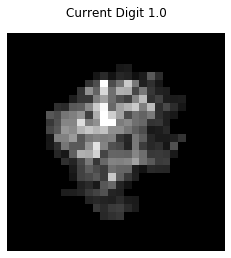

In [8]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.matshow(numb_image[0], cmap = 'gray')
ax1.set_title('Current Digit {}'.format(numb_id[0]))
ax1.axis('off')

(-0.5, 27.5, 27.5, -0.5)

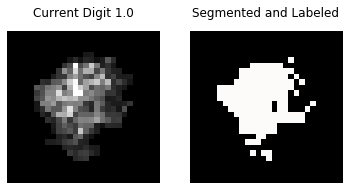

In [9]:
from skimage.measure import label # connected component labeling
def seg_and_label(in_image):
    norm_image = (in_image - in_image.mean())/in_image.std()
    return (norm_image>0.5).astype(np.uint8)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.matshow(numb_image[0], cmap = 'gray')
ax1.set_title('Current Digit {}'.format(numb_id[0]))
ax1.axis('off')
ax2.matshow(seg_and_label(numb_image[0]),cmap='gist_earth')
ax2.set_title('Segmented and Labeled')
ax2.axis('off')

# Shape Analysis

Used on image to quantify it in a few simple parameters

In [10]:
from skimage.measure import regionprops
def shape_analysis(in_label):
    try:
        mean_anisotropy=np.mean([(freg.major_axis_length-freg.minor_axis_length)/freg.minor_axis_length 
                                 for freg in regionprops(in_label)])
    except ZeroDivisionError:
        mean_anisotropy = 0
    return dict(
           total_area=np.sum([freg.area for freg in regionprops(in_label)]),
    total_perimeter=np.sum([freg.perimeter for freg in regionprops(in_label)]),
    mean_anisotropy=mean_anisotropy,
        mean_orientation=np.mean([freg.orientation for freg in regionprops(in_label)])
               )

shape_analysis(seg_and_label(numb_image[0]))



/Users/sav/opt/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/sav/opt/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


{'total_area': 151,
 'total_perimeter': 60.83452377915607,
 'mean_anisotropy': 0.08432950318878561,
 'mean_orientation': 1.3293836392660503}

In [13]:
# Make it into a feature vector
def full_analysis(in_img):
    return np.array(list(shape_analysis(seg_and_label(in_img)).values()))

# Building a Classifier

We use the same simple classifier as before but with the shape features instead of the image

**Dataset:**

Equal images per each shape form group 30 images (3 sets of 10 images per shape group)

 - 3 form categories: Line, Circle, Blob (parenchyma vs. cerebrovasculature)

**Steps:**
 - 1) Create a compiled .csv file data frame to hold all pixels (reshaped as 28x28)
 - 2) Split images into train vs. test data (15 per dataset, equal amounts of each shape)
 - 3) Label connected components
 - 4) Perform shape analysis to quantify image with few parameters (i.e. anisotropy, mean orientation, total area, perimeter)
 - 5) Build a classifier using these shape features
 - 6) Use MAE (mean absolute error) to find best match

In [14]:
digit_examples = {} # we use a dictionary to store the results
digit_features = {} # we use a dictionary to store the results

for cur_digit in np.unique(numb_id):
    # find the first example
    digit_matches = np.where(numb_id == cur_digit)
    digit_examples[cur_digit] = numb_image[digit_matches[0][0]]
    digit_features[cur_digit] = full_analysis(numb_image[digit_matches[0][0]])

**3 categories of forms:** Blob (1), Circle (2), Line (3)

Digit 1.0
[1.51000000e+02 6.08345238e+01 8.43295032e-02 1.32938364e+00]
Digit 2.0
[1.86000000e+02 9.83969696e+01 6.65136796e-02 2.77951191e-01]
Digit 3.0
[84.         57.49137803  3.27685484 -0.71116957]


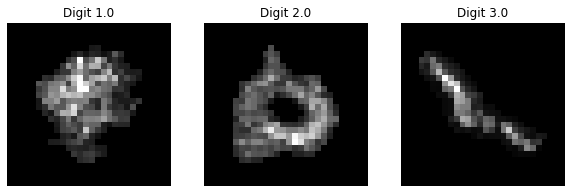

In [15]:
fig, c_axs = plt.subplots(1, len(digit_examples), figsize = (10, 3))
for c_ax, (c_digit, c_img) in zip(c_axs, digit_examples.items()):
    c_ax.imshow(c_img, cmap = 'gray', interpolation = 'none')
    c_ax.set_title('Digit {}'.format(c_digit))
    c_ax.axis('off')
    print('Digit {}'.format(c_digit))
    print(full_analysis(c_img))

In [16]:
# Using the dictionary of example digits we can build a very simple classifier using the MAE (mean absolute error) to find the best match

def mae(fvec1,fvec2):
    return np.mean(np.abs(fvec1-fvec2))

def classify_image(example_dict, in_image):
    score_dict = {c_digit: mae(full_analysis(in_image), c_fvec) for c_digit, c_fvec in example_dict.items()}
    best_digit, best_score = sorted(score_dict.items(), key = lambda x: x[1])[0] # sort by score and take the first item
    return best_digit, score_dict

Guessed 1.0, actual result was 1.0
Score for other numbers: {1.0: 5.564495359990337, 2.0: 16.906285697030317, 3.0: 20.329560714868098}


Text(0.5, 1.0, 'MAE for each digit feature vector')

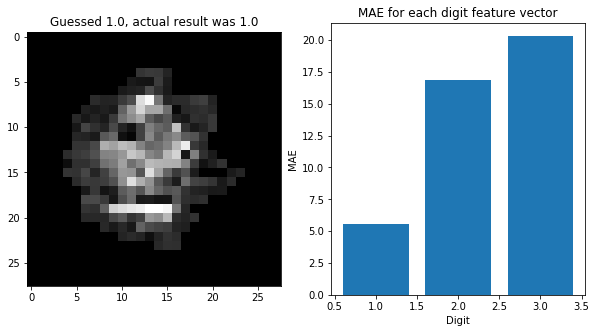

In [18]:
rand_digit = np.random.choice(range(len(numb_image))) # just picks a random digit

guess_digit, guess_dict = classify_image(digit_features, numb_image[rand_digit])
print('Guessed {}, actual result was {}'.format(guess_digit, numb_id[rand_digit]))
print('Score for other numbers:', guess_dict)
# show the results
fig, (ax_img, ax_score) = plt.subplots(1,2, figsize = (10, 5))
ax_img.imshow(numb_image[rand_digit], cmap = 'gray', interpolation = 'none')
ax_img.set_title('Guessed {}, actual result was {}'.format(guess_digit, numb_id[rand_digit]))
ax_score.bar(list(guess_dict.keys()), list(guess_dict.values()))
ax_score.set_xlabel('Digit')
ax_score.set_ylabel('MAE')
ax_score.set_title('MAE for each digit feature vector')

Let's try one more time...

Guessed 3.0, actual result was 3.0
Score for other numbers: {1.0: 18.894056074858437, 2.0: 36.77626337892274, 3.0: 0.0}


Text(0.5, 1.0, 'MAE for each digit feature vector')

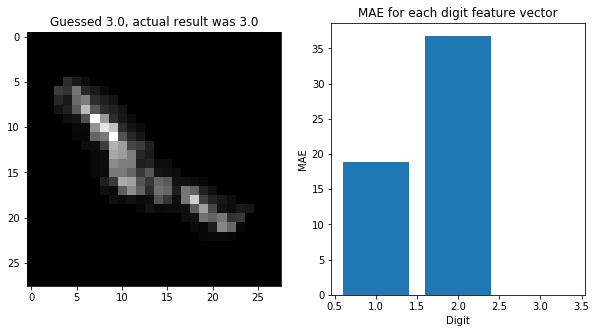

In [21]:
rand_digit = np.random.choice(range(len(numb_image))) # just picks a random digit

guess_digit, guess_dict = classify_image(digit_features, numb_image[rand_digit])
print('Guessed {}, actual result was {}'.format(guess_digit, numb_id[rand_digit]))
print('Score for other numbers:', guess_dict)
# show the results
fig, (ax_img, ax_score) = plt.subplots(1,2, figsize = (10, 5))
ax_img.imshow(numb_image[rand_digit], cmap = 'gray', interpolation = 'none')
ax_img.set_title('Guessed {}, actual result was {}'.format(guess_digit, numb_id[rand_digit]))
ax_score.bar(list(guess_dict.keys()), list(guess_dict.values()))
ax_score.set_xlabel('Digit')
ax_score.set_ylabel('MAE')
ax_score.set_title('MAE for each digit feature vector')

# Submit an Entry

We can now submit an entry to the contest by running our digit classifier on all of the test images. 
The data for the test images is the same as the training data but there are no labels.

In [18]:
test_vec = np.loadtxt(test_data_path, delimiter = ',', skiprows = 1)
print('Test Vec', test_vec.shape)

Test Vec (14, 784)


In [19]:
test_image = test_vec.reshape(-1, 28, 28)
print('Test Image', test_image.shape)

Test Image (14, 28, 28)


# Predict a form for each image

Here we make a guess for each image by using our classify_image function and just keeping the first result (the digit) and not the entire dictionary

In [21]:
%%time
guess_test_data = [classify_image(digit_features, c_img)[0] for c_img in test_image]

Wall time: 58 ms


In [34]:
with open('submission.csv', 'w') as out_file:
    out_file.write('ImageId,Label\n')
    for img_id, guess_label in enumerate(guess_test_data):
        out_file.write('%d,%d\n' % (img_id+1, guess_label))

# Future Analysis
<br>

### **Additional parameters that can be used for shape analysis?**
 - **Directional Analysis:** 
     - Looking at the orientation of different components using Fourier analysis (Analyze Directionality)
 - **Tubeness / Surfaceness:** 
     - Characterize binary images and the shape at each point similar to curvature but with a different underlying model
     - Tubeness: Enhances filamentous structures of a specified thickness (trace neurons)


### **Advanced Investigation of Surface Structure** 

 - **Curvature:** Visual indication of cell differences (amyloid is the most circular item in the image) independent of its size
 - **Interface - Perimeter:** Help differentiate connectivity of cell networks
 - **Further Texture Analysis:** what feature detections are best correlated with amyloid object (i.e. co-occurrence matrix) 
     - Contrast 
         - Dissimilarity 
         - Homogeneity
     - Orderliness
         - How regular (“orderly”) the pixel value differences are
     - Entropy / Energy
         - Higher entropy value indicates greater complex variability (i.e. yields more useful information vs. “fog” image consisting of identical pixels)
         - ASM (Angular second moment) - orderly
     - Correlation
         - Measures linear dependency of grey levels on those of neighboring pixels 
